# Variational autoencoders

In this homework you will train a variational autoencoder on the Frey dataset and inspect the results.

In [1]:
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt

## Data loading and pre-processing

Here we download and unpack the Frey dataset.  The dataset consists of grayscale images, 28 pixels high and 20 pixels wide.

In [2]:
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

path = get_file('frey_rawface.mat','https://cs.nyu.edu/~roweis/data/frey_rawface.mat')
data = np.transpose(loadmat(path)['ff'])
images = np.reshape(data,(-1,28,20))
np.random.seed(1234)
np.random.shuffle(images)

(1965, 28, 20)


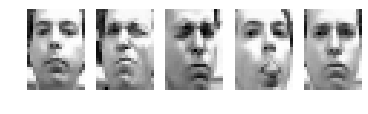

In [3]:
print(images.shape)
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

We split the data into training and testing splits (the data was shuffled above) and then convert to floating point on [-1 1] range.

In [4]:
x_train = images[0:1800]
x_test = images[1800:]
x_train = (x_train.astype('float32')/255.)*2-1
x_test = (x_test.astype('float32')/255.)*2-1

## Model implementation and training

I have given the implementation of the variational autoencoder here, based on [the example from the Keras Github repository](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py).

The original paper introducing this model [can be found here](https://arxiv.org/pdf/1312.6114.pdf).

In [5]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K

class Autoencoder:
  def __init__(self,reconstruction_weight=1):
    # two hidden layers in encoder:
    self.encoder_layer1 = Dense(512,activation='relu',name='encoder1')
    self.encoder_layer2 = Dense(512,activation='relu',name='encoder2')
    
    # encoder outputs mean and log variance of latent vector
    self.encoder_mean = Dense(2,activation=None,name='mean')
    self.encoder_log_var = Dense(2,activation=None,name='log_var')
    
    # decoder with two hidden layers
    self.decoder_layer1 = Dense(512,activation='relu',name='decoder1')
    self.decoder_layer2 = Dense(512,activation='relu',name='decoder2')
    self.decoder_layer3 = Dense(28*20,activation=None,name='decoder3')
 
    self.reconstruction_weight = reconstruction_weight

  def get_autoencoder(self):
    """ Builds the full autoencoder model with encoder and decoder. """
    inputs = Input((28,20),name='autoencoder_input')
    flattened_inputs = Flatten()(inputs)
    x = self.encoder_layer1(flattened_inputs)
    x = self.encoder_layer2(x)
    z_mean = self.encoder_mean(x)
    z_log_var = self.encoder_log_var(x)
    
    # this function samples the latent vector z ~ q(z|x)
    # using the "reparamterization trick"
    def sampling(args):
      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon
    z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
    
    # decode the sampled latent vector
    x = self.decoder_layer1(z)
    x = self.decoder_layer2(x)
    flattened_outputs = self.decoder_layer3(x)
    outputs = Reshape((28,20))(flattened_outputs)
    
    # build the model from input to output
    model = Model(inputs=inputs,outputs=outputs)
    
    # build the loss function
    reconstruction_loss = mse(flattened_inputs, flattened_outputs)
    reconstruction_loss *= 28*20*self.reconstruction_weight
    
    # this is the KL-divergence term
    # it can be derived analytically for Gaussian q and p (see paper appendix)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    # the total loss is the sum of reconstruction and KL
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    model.add_loss(vae_loss)
    
    return model
   
  def get_encoder(self):
    """ Builds just the encoder model. """
    inputs = Input((28,20),name='encoder_input')
    x = Flatten()(inputs)
    x = self.encoder_layer1(x)
    x = self.encoder_layer2(x)
    x = self.encoder_mean(x)
    return Model(inputs=inputs,outputs=x)
  
  def get_decoder(self):
    """ Builds just the decoder model. """
    embedding = Input((2,),name='decoder_input')
    x = embedding
    x = self.decoder_layer1(x)
    x = self.decoder_layer2(x)
    x = self.decoder_layer3(x)
    outputs = Reshape((28,20))(x)
    return Model(inputs=embedding,outputs=outputs)

autoencoder = Autoencoder()

ae_model = autoencoder.get_autoencoder()
encoder_model = autoencoder.get_encoder()
decoder_model = autoencoder.get_decoder()

ae_model.compile(SGD(0.001,momentum=0.9))
print(ae_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 28, 20)       0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 560)          0           autoencoder_input[0][0]          
__________________________________________________________________________________________________
encoder1 (Dense)                (None, 512)          287232      flatten[0][0]                    
__________________________________________________________________________________________________
encoder2 (Dense)                (None, 512)          262656      encoder1[0][0]                   
__________________________________________________________________________________________________
mean (Dens

In [6]:
history = ae_model.fit(x_train,batch_size=32,epochs=1000,verbose=False,validation_split=0.1)

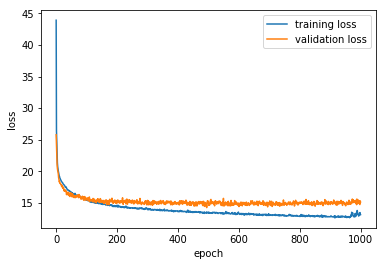

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss','validation loss'])
plt.show()

## Exercises

* Test the ability of the autoencoder to compress and decompress the images.  Compare some input images to their reconstructions after running the autoencoder.  What effect does the autoencoder have on the images?
* Visualize the output of the encoder (run on the training data) as a scatter plot.  Give some observations about the output.  Does the embedding seem to follow a Gaussian distribution?
* Generate new faces by making a grid of embedding points on $[-3~3]\times[-3~3]$ (see code below).  Give some observations about the resulting images.
* Now generate new faces by sampling embedding points from a normal distribution with zero mean and unit variance (see numpy.random.normal). Do the generated images look plausible?  What can you conclude about the performance of the VAE from this?
* Test what happens if you change the balance between the reconstruction error term and the KL-divergence term in the VAE loss function.  Multiply the reconstruction loss by 5 (using the reconstruction_weight argument to the Autoencoder class), re-train the model, plot the embedding, and show some reconstructed images.  Then, multiply the reconstruction loss by .02 instead and repeat.  How does the balance between the two terms affect the image reconstruction quality and the shape of the embedding?


##### 1. Test the ability of the autoencoder to compress and decompress the images.  Compare some input images to their reconstructions after running the autoencoder.  What effect does the autoencoder have on the images?

The variational autoencoder is able to create close representations of the original input images. I have noticed that the output images are "smoother" than that of the input images. The visual affect looks like a slight blur was applied to each of the input images. This affect is expected because some of the information is being lost during compression. Similarly to the undercomplete autoencoder in the last lab, the variational autoencoder is not able to reconstruct images where the man's tongue is sticking out. Additionally, sharp lines that are present in the input image are not as clearly drawn in the reconstructed image.

Row 1 = Input Images
Row 2 = Reconstructed Images


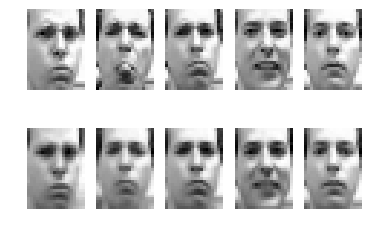

In [20]:
# Example input images and their reconstructions:
num_samples = 5
index_pos = np.random.choice(len(x_test), num_samples)
images_in = x_test[index_pos]

# Run the autoencoder on each image
images_out = ae_model.predict(images_in)
print("Row 1 = Input Images\nRow 2 = Reconstructed Images")
# Display original images
for i in range(num_samples):
  plt.subplot(2,num_samples,i+1)
  plt.imshow(images_in[i])
  plt.axis('off')
# Display reconstructed images
for i in range(num_samples):
  plt.subplot(2,num_samples,i+num_samples+1)
  plt.imshow(images_out[i])
  plt.axis('off')
plt.show()

##### 2. Visualize the output of the encoder (run on the training data) as a scatter plot.  Give some observations about the output.  Does the embedding seem to follow a Gaussian distribution?

The visualized encodings take up a large area in the scatter plot. This is a better result than that of the undercomplete autoencoder in the previous lab because the output resembles a more random distribution. From this distribution, we can more easily sample points. The question asks whether or not the embeddings seem to follow a Gaussian distribution. Gaussian distributions cluster their points at the center of the scatter plot and less so as the fringes. My distribution looks more random than a Gaussian distribution because we can observe clusters at the fringes. 

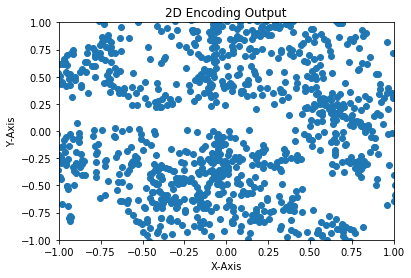

In [8]:
images_out = encoder_model.predict(x_train)
x = [x[0] for x in images_out]
y = [x[1] for x in images_out]
plt.scatter(x, y)
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("2D Encoding Output")
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

##### 3. Generate new faces by making a grid of embedding points on $[-3~3]\times[-3~3]$.  Give some observations about the resulting images.

Much like the undercomplete autoencoder's embedding space, the variational autoencoder's embedding space organizes the images so that similar facial features can be found near each other. In the generated output space, it appears that the man's face turns from left to right across the x axis. At high y values, the man is frowning. At mid-range y values, the man is opening his mouth to either smile or make a "O" with his lips. And at low y values, the man's mouth is closed. One last interesting observation is that the model clustered all the images of the man sticking his tongue out at the corner with low y values and high x values. When I look compare these results to the undercomplete autoencoder results, it appears that the variational autoencoder organizes the embeddings more logically, as there appears to be smoother transitions between images. 

(100, 2)


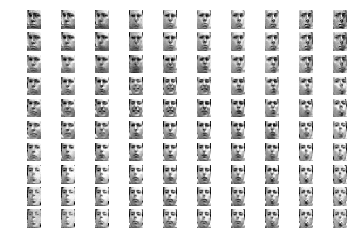

In [13]:
coords = np.linspace(-3,3,num=10)
x,y = np.meshgrid(coords,coords,indexing='xy')
embeddings = np.stack([x.flatten(),y.flatten()],axis=1)
# plt.scatter(embeddings[:,0],embeddings[:,1])
# plt.show()

# Generate an image from each area in the output space
print(embeddings.shape)
images = decoder_model.predict(embeddings)

width = height = 10
totalPoints = width * height
for i in range(totalPoints):
  plt.subplot(width,height,i+1)
  plt.imshow(np.squeeze(images[i]))
  plt.axis('off')

##### 4. Now generate new faces by sampling embedding points from a normal distribution with zero mean and unit variance (see numpy.random.normal). Do the generated images look plausible?  What can you conclude about the performance of the VAE from this?

The varational autoencoder certainly creates images that are plausible (very occasionally it will create an image that is straight out of a horror show). It can generate images that vary in the man's orientation and facial expression. One time, I was surprised that it generated an image of the man's tongue slightly out of his mouth, which is something I did not observe with the undercomplete autoencoder. From my experimentation, I believe that the VAE performs better than that of the undercomplete AE because its sample more closely represent the training images and because the distribution of the embedded space can more easily be modeled. 

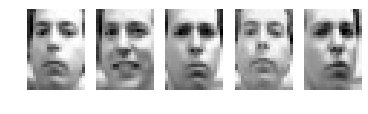

In [47]:
samples = 5
def generate(samples, decoder_model):
    mu, sigma = 0, 1 # mean and standard deviation
    xs = np.random.normal(mu, sigma, samples)
    ys = np.random.normal(mu, sigma, samples)
    inputs = np.array(list(zip(xs, ys)))

    images_out = decoder_model.predict(inputs)

    cols = samples
    for i in range(samples):
        plt.subplot(1, cols, i+1)
        plt.imshow(images_out[i])
        plt.axis('off')
generate(samples, decoder_model)

##### 5. Test what happens if you change the balance between the reconstruction error term and the KL-divergence term in the VAE loss function.  Multiply the reconstruction loss by 5 (using the reconstruction_weight argument to the Autoencoder class), re-train the model, plot the embedding, and show some reconstructed images.  Then, multiply the reconstruction loss by .02 instead and repeat.  How does the balance between the two terms affect the image reconstruction quality and the shape of the embedding?

When the model weights the reconstruction loss more than that of the KL-divergence, the distribution of the model's embeddings no longer takes the shape of a random or Gaussian distribution. The scatter plot appears to have a hole in the middle, as if the model is pushing all the points to the fringes of the graph. As a result, the model's loss is much higher during training. Despite this high loss, the model is still able to generate a variety of diverse images from sampled from a normal distribution. 

When the model weights the reconstruction loss less than that of the KL-divergence, the distribution of the model's embeddings is centered around X=0.0 and Y=0.0. It appears that the model is pulling all the points towards the center of the graph. However, we observe a much smaller amount of loss during training. Despite this low loss, the model does not generate high quality samples. All the sample look very similar to each other, which is an undersired behavior.

Overall, it appears that as the reconstruction loss increases in weight, the variety of output images increases as well as the spread of the embedded points in the scatter plot. Using my oberservations, it is important to find a happy balance between these two terms so that the distribution of the embedded points is roughly random (or Gaussian) and the the loss is as small as possible without compromixing the variety of output imges. 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 28, 20)       0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 560)          0           autoencoder_input[0][0]          
__________________________________________________________________________________________________
encoder1 (Dense)                (None, 512)          287232      flatten_2[0][0]                  
__________________________________________________________________________________________________
encoder2 (Dense)                (None, 512)          262656      encoder1[0][0]                   
__________________________________________________________________________________________________
mean (Dens

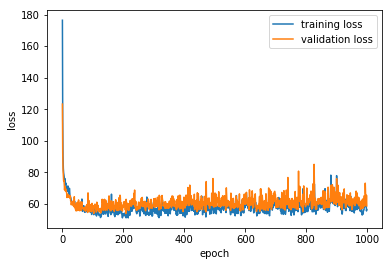

In [40]:
autoencoder_highR = Autoencoder(reconstruction_weight=5)
ae_model_highR = autoencoder_highR.get_autoencoder()
encoder_model_highR = autoencoder_highR.get_encoder()
decoder_model_highR = autoencoder_highR.get_decoder()
ae_model_highR.compile(SGD(0.001,momentum=0.9))
print(ae_model_highR.summary())
history = ae_model_highR.fit(x_train,batch_size=32,epochs=1000,verbose=False,validation_split=0.1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss','validation loss'])
plt.show()

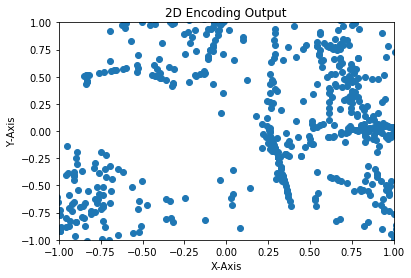

In [42]:
images_out = encoder_model_highR.predict(x_train)
x = [x[0] for x in images_out]
y = [x[1] for x in images_out]
plt.scatter(x, y)
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("2D Encoding Output")
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

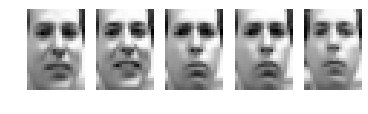

In [48]:
generate(5, decoder_model_highR)

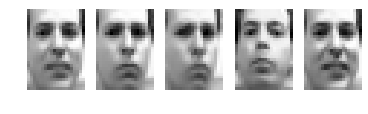

In [49]:
generate(5, decoder_model_highR)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 28, 20)       0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 560)          0           autoencoder_input[0][0]          
__________________________________________________________________________________________________
encoder1 (Dense)                (None, 512)          287232      flatten_4[0][0]                  
__________________________________________________________________________________________________
encoder2 (Dense)                (None, 512)          262656      encoder1[0][0]                   
__________________________________________________________________________________________________
mean (Dens

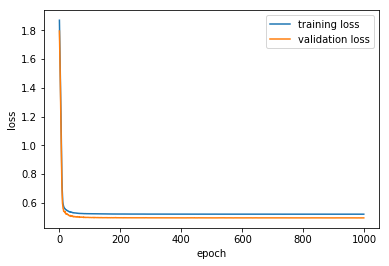

In [41]:
autoencoder_lowR = Autoencoder(reconstruction_weight=0.02)
ae_model_lowR = autoencoder_lowR.get_autoencoder()
encoder_model_lowR = autoencoder_lowR.get_encoder()
decoder_model_lowR = autoencoder_lowR.get_decoder()
ae_model_lowR.compile(SGD(0.001,momentum=0.9))
print(ae_model_lowR.summary())
history = ae_model_lowR.fit(x_train,batch_size=32,epochs=1000,verbose=False,validation_split=0.1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss','validation loss'])
plt.show()

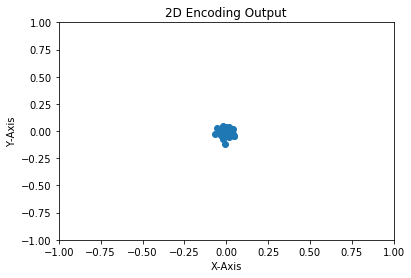

In [43]:
images_out = encoder_model_lowR.predict(x_train)
x = [x[0] for x in images_out]
y = [x[1] for x in images_out]
plt.scatter(x, y)
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("2D Encoding Output")
plt.ylim(-1,1)
plt.xlim(-1,1)
plt.show()

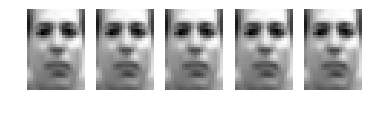

In [50]:
generate(5, decoder_model_lowR)

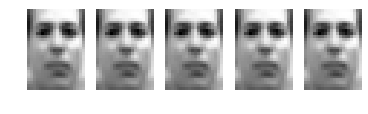

In [51]:
generate(5, decoder_model_lowR)